In [143]:
!pip install sastrawi

In [144]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)

from keras.layers import Dense, LeakyReLU, SimpleRNN, LSTM
from keras.models import Sequential
from keras.optimizers import Adam
from keras import models
from keras import layers

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import datetime as dt
import string
import re

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory


import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

import csv
import requests
from io import StringIO

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jayaw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jayaw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jayaw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Memuat Dataset

In [145]:
app_reviews_df = pd.read_csv('dataset.csv')

In [146]:
jumlah_ulasan, jumlah_kolom = app_reviews_df.shape

In [147]:
app_reviews_df.head()

,Review
0,"Rusak scan,Qris sulit terbaca kadang tidak bisa ngebaca..!!! Sulit bener untuk bertransaksi selalu ada hambatan...!! Sudah puluhan kali transfer selalu terkendala, anehnya setelah memberi ulasan di playstore langsung bisa transaksi..!!!! Transaksi selalu gagal... capek... ngulang ngulang...muter muter...!!!"
1,"Apk udah bagus tapi masih berasa berat , kalau bisa latar gambar yang ada di dalam apk jangan di buat gambar bergerak . Seperti nya karna gambar gerak itu apk dana jadi berat . Pencet fitur aja gk langsung masuk tapi ada stuck nya . Sama 1 lagi bebas biaya admin jangan di hapus , sebab itu buat pengguna yang kurang mampu jadi nyaman dan mudah . Trus adakan bebas biaya admin jangan di hapus."
2,"Aplikasinya sangat bagus diawal2 nya terutama transaksinya sangat membantu, tapi untuk update nya sangat lemot sekali dan saat sekarang juga kalau buka aplikasinya sangat lambat sekali alias lemot..jadi kalau mau transaksi saat ini sangat kesel harus nya segera dong di benahi..makasih"
3,Animasi promo yang kalian buat membuat aplikasi nya menjadi patah patah saat digunakan terlebih ketika meng-scroll app nya. Bisakah untuk setidaknya mengurangi animasinya atau membuat opsi di pengaturan terkait hal tersebut
4,"aplikasi makin kesini makin lemot saja... padahal koneksi bagus, sinyal manteng, kenapa pas awal buka dana jadi lemot, apalagi pas mau transaksi makin lemot saja... tolong untuk pihak pengembang untuk di perbaiki permasalahan lemot ini... coba di uji coba pakai hp jadul yang ram kecil, karena gak semua pengguna aplikasi dana mempunyai hp yang speknya bagus. terimakasih."


# Menghapus Data Kosong dan Data Duplikat

In [148]:
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126000 entries, 0 to 125999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Review  126000 non-null  object
dtypes: object(1)
memory usage: 984.5+ KB


In [149]:
clean_df = app_reviews_df.dropna()

In [150]:
clean_df.drop_duplicates(inplace=True)

In [151]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124209 entries, 0 to 125999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Review  124209 non-null  object
dtypes: object(1)
memory usage: 1.9+ MB


In [152]:
jumlah_ulasan_bersih, jumlah_kolom_bersih = clean_df.shape

# Preprocessing Text

In [153]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')

    return text

In [154]:
def casefoldingText(text):
    text = text.lower()
    return text

In [155]:
def tokenizingText(text):
    text = word_tokenize(text)
    return text

### Mendeteksi Stop Words

In [156]:
list_stop_words = set(stopwords.words('indonesian'))
list_stop_words.update(set(stopwords.words('english')))
list_stop_words

{'a',
 'about',
 'above',
 'ada',
 'adalah',
 'adanya',
 'adapun',
 'after',
 'again',
 'against',
 'agak',
 'agaknya',
 'agar',
 'ain',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'all',
 'am',
 'amat',
 'amatlah',
 'an',
 'and',
 'anda',
 'andalah',
 'antar',
 'antara',
 'antaranya',
 'any',
 'apa',
 'apaan',
 'apabila',
 'apakah',
 'apalagi',
 'apatah',
 'are',
 'aren',
 "aren't",
 'artinya',
 'as',
 'asal',
 'asalkan',
 'at',
 'atas',
 'atau',
 'ataukah',
 'ataupun',
 'awal',
 'awalnya',
 'bagai',
 'bagaikan',
 'bagaimana',
 'bagaimanakah',
 'bagaimanapun',
 'bagi',
 'bagian',
 'bahkan',
 'bahwa',
 'bahwasanya',
 'baik',
 'bakal',
 'bakalan',
 'balik',
 'banyak',
 'bapak',
 'baru',
 'bawah',
 'be',
 'beberapa',
 'because',
 'been',
 'before',
 'begini',
 'beginian',
 'beginikah',
 'beginilah',
 'begitu',
 'begitukah',
 'begitulah',
 'begitupun',
 'being',
 'bekerja',
 'belakang',
 'belakangan',
 'below',
 'belum',
 'belumlah',
 'benar',
 'benarkah',
 

In [157]:
all_words = ' '.join(clean_df['Review']).split()
word_counts = pd.Series(all_words).value_counts()
print(word_counts)

di               80639
saya             74504
dana             59629
bisa             56714
tidak            44761
                 ...  
admin2nya...         1
500ny                1
500.dan              1
lagi😇                1
future/IFLIX,        1
Name: count, Length: 170592, dtype: int64


In [158]:
most_frequent_words = [i for i in word_counts.index if i not in list_stop_words]
most_frequent_words

['dana',
 'nya',
 'aplikasi',
 'saldo',
 'gak',
 'ga',
 'yg',
 'transaksi',
 'masuk',
 'uang',
 'udah',
 'akun',
 'aja',
 'Saya',
 'update',
 'apk',
 'tolong',
 'premium',
 'Aplikasi',
 'gk',
 'top',
 'pake',
 ',',
 'transfer',
 'upgrade',
 'banget',
 'Tolong',
 'bagus',
 'login',
 'DANA',
 'Dana',
 'ya',
 'buka',
 'pulsa',
 'perbaiki',
 'pakai',
 'kali',
 'kirim',
 'pas',
 'Kenapa',
 'hilang',
 'udh',
 'susah',
 '.',
 'gagal',
 'kalo',
 'kecewa',
 'jaringan',
 'kasih',
 'isi',
 'gimana',
 'nomor',
 'email',
 'suruh',
 'membantu',
 'coba',
 'verifikasi',
 'bintang',
 'mudah',
 'pembayaran',
 'sih',
 'tp',
 'pin',
 'beli',
 'sistem',
 'data',
 '1',
 'Ini',
 '2',
 'respon',
 'hp',
 'mohon',
 'Sangat',
 'cs',
 'bank',
 'chat',
 'Padahal',
 'dana,',
 'pengguna',
 'berhasil',
 'sy',
 'proses',
 'bikin',
 'kode',
 'jam',
 'fitur',
 'orang',
 'cepat',
 'aplikasinya',
 'suka',
 'Sudah',
 'langsung',
 'Mohon',
 'gabisa',
 'sampe',
 'nunggu',
 'muncul',
 'karna',
 'bayar',
 'ribet',
 'tdk',
 'di

In [159]:
list_stop_words.update(['iya','yaa','gak','nya','na','sih','ku','di','ga','ya','gaa','loh','kah','woi','woii','woy', 'udah', 'yg', 'aja', 'pas', 'udh', 'tp', 'padahal', 'trus', 'tpi', 'gini', 'gitu', 'emang', 'ga', 'kalo', 'doang', 'kek', 'donk', 'gada'])

In [160]:
def filteringText(text, list_stop_words=list_stop_words):
    filtered = []
    for txt in text:
        if txt not in list_stop_words:
            filtered.append(txt)
    text = filtered
    return text

In [161]:
def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    words = text.split()

    stemmed_words = [stemmer.stem(word) for word in words]

    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

In [162]:
def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [163]:
slangwords = {'@': 'di', 'abis': 'habis', 'wtb': 'beli', 'masi': 'masih', 'wts': 'jual', 'wtt': 'tukar', 'bgt': 'banget', 'maks': 'maksimal'}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [164]:
clean_df['text_clean'] = clean_df['Review'].apply(cleaningText)
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)
clean_df['text_stopwords'] = clean_df['text_tokenizingText'].apply(filteringText)
clean_df['final_text'] = clean_df['text_stopwords'].apply(toSentence)

In [165]:
clean_df.head()

,Review,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopwords,final_text
0,"Rusak scan,Qris sulit terbaca kadang tidak bisa ngebaca..!!! Sulit bener untuk bertransaksi selalu ada hambatan...!! Sudah puluhan kali transfer selalu terkendala, anehnya setelah memberi ulasan di playstore langsung bisa transaksi..!!!! Transaksi selalu gagal... capek... ngulang ngulang...muter muter...!!!",Rusak scanQris sulit terbaca kadang tidak bisa ngebaca Sulit bener untuk bertransaksi selalu ada hambatan Sudah puluhan kali transfer selalu terkendala anehnya setelah memberi ulasan di playstore langsung bisa transaksi Transaksi selalu gagal capek ngulang ngulangmuter muter,rusak scanqris sulit terbaca kadang tidak bisa ngebaca sulit bener untuk bertransaksi selalu ada hambatan sudah puluhan kali transfer selalu terkendala anehnya setelah memberi ulasan di playstore langsung bisa transaksi transaksi selalu gagal capek ngulang ngulangmuter muter,rusak scanqris sulit terbaca kadang tidak bisa ngebaca sulit bener untuk bertransaksi selalu ada hambatan sudah puluhan kali transfer selalu terkendala anehnya setelah memberi ulasan di playstore langsung bisa transaksi transaksi selalu gagal capek ngulang ngulangmuter muter,"[rusak, scanqris, sulit, terbaca, kadang, tidak, bisa, ngebaca, sulit, bener, untuk, bertransaksi, selalu, ada, hambatan, sudah, puluhan, kali, transfer, selalu, terkendala, anehnya, setelah, memberi, ulasan, di, playstore, langsung, bisa, transaksi, transaksi, selalu, gagal, capek, ngulang, ngulangmuter, muter]","[rusak, scanqris, sulit, terbaca, kadang, ngebaca, sulit, bener, bertransaksi, hambatan, puluhan, kali, transfer, terkendala, anehnya, ulasan, playstore, langsung, transaksi, transaksi, gagal, capek, ngulang, ngulangmuter, muter]",rusak scanqris sulit terbaca kadang ngebaca sulit bener bertransaksi hambatan puluhan kali transfer terkendala anehnya ulasan playstore langsung transaksi transaksi gagal capek ngulang ngulangmuter muter
1,"Apk udah bagus tapi masih berasa berat , kalau bisa latar gambar yang ada di dalam apk jangan di buat gambar bergerak . Seperti nya karna gambar gerak itu apk dana jadi berat . Pencet fitur aja gk langsung masuk tapi ada stuck nya . Sama 1 lagi bebas biaya admin jangan di hapus , sebab itu buat pengguna yang kurang mampu jadi nyaman dan mudah . Trus adakan bebas biaya admin jangan di hapus.",Apk udah bagus tapi masih berasa berat kalau bisa latar gambar yang ada di dalam apk jangan di buat gambar bergerak Seperti nya karna gambar gerak itu apk dana jadi berat Pencet fitur aja gk langsung masuk tapi ada stuck nya Sama lagi bebas biaya admin jangan di hapus sebab itu buat pengguna yang kurang mampu jadi nyaman dan mudah Trus adakan bebas biaya admin jangan di hapus,apk udah bagus tapi masih berasa berat kalau bisa latar gambar yang ada di dalam apk jangan di buat gambar bergerak seperti nya karna gambar gerak itu apk dana jadi berat pencet fitur aja gk langsung masuk tapi ada stuck nya sama lagi bebas biaya admin jangan di hapus sebab itu buat pengguna yang kurang mampu jadi nyaman dan mudah trus adakan bebas biaya admin jangan di hapus,apk udah bagus tapi masih berasa berat kalau bisa latar gambar yang ada di dalam apk jangan di buat gambar bergerak seperti nya karna gambar gerak itu apk dana jadi berat pencet fitur aja gk langsung masuk tapi ada stuck nya sama lagi bebas biaya admin jangan di hapus sebab itu buat pengguna yang kurang mampu jadi nyaman dan mudah trus adakan bebas biaya admin jangan di hapus,"[apk, udah, bagus, tapi, masih, berasa, berat, kalau, bisa, latar, gambar, yang, ada, di, dalam, apk, jangan, di, buat, gambar, bergerak, seperti, nya, karna, gambar, gerak, itu, apk, dana, jadi, berat, pencet, fitur, aja, gk, langsung, masuk, tapi, ada, stuck, nya, sama, lagi, bebas, biaya, admin, jangan, di, hapus, sebab, itu, buat, pengguna, yang, kurang, mampu, jadi, nyaman, dan, mudah, trus, adakan, bebas, biaya, admin, jangan, di, hapus]","[apk, bagus, berasa

# Memberi Label pada Data

In [166]:
lexicon_positive = dict()
lexicon_negative = dict()

In [167]:
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

In [168]:
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')

    for row in reader:
        lexicon_positive[row[0]] = int(row[1])

else:
    print('Gagal')

In [169]:
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

In [170]:
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')

    for row in reader:
        lexicon_negative[row[0]] = int(row[1])

else:
    print('Gagal')

In [171]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0

    for word in text:
        if(word in lexicon_positive):
            score = score + lexicon_positive[word]

    for word in text:
        if(word in lexicon_negative):
            score = score + lexicon_negative[word]

    polarity=''

    if(score>0):
        polarity = 'positive'
    elif(score<0):
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

In [172]:
results = clean_df['text_stopwords'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
positive    61631
negative    54278
neutral      8300
Name: count, dtype: int64


## Menampilkan Word Cloud pada setiap Sentiment

In [173]:
def merge_text(df, column, category):
    text = ' '.join(df[df[column] == category]['final_text'])
    return text

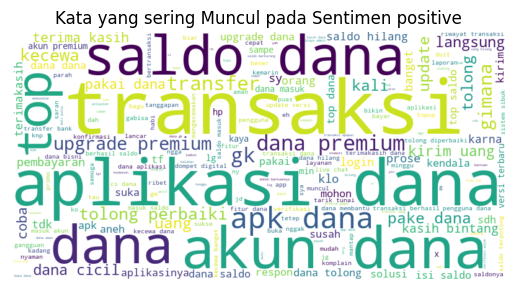

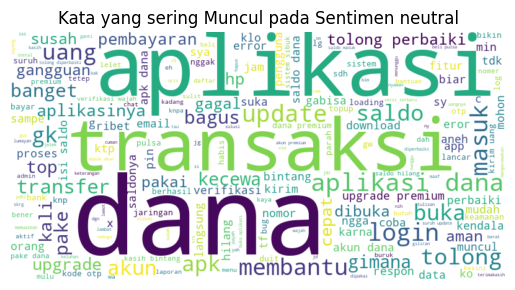

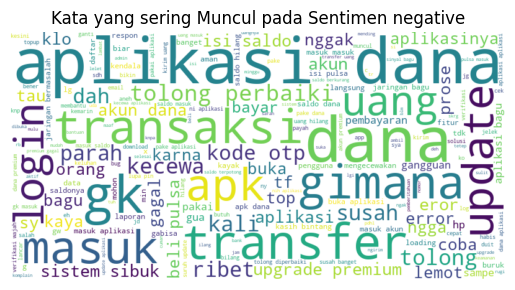

In [175]:
for i in ['positive', 'neutral', 'negative']:
    text = merge_text(clean_df,'polarity',i)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Kata yang sering Muncul pada Sentimen {i}')
    plt.axis('off')
    plt.show()

# Data Splitting dan Ektraksi Fitur

In [70]:
x = clean_df['final_text']
y = clean_df['polarity']

In [71]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

In [72]:
x_train, x_temp, y_train, y_temp = train_test_split(x, y_encoded, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [73]:
tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8)

In [74]:
x_train_tfidf = tfidf.fit_transform(x_train)
x_val_tfidf = tfidf.transform(x_val)
x_test_tfidf = tfidf.transform(x_test)

In [75]:
features_df = pd.DataFrame(x_train_tfidf.toarray(), columns=tfidf.get_feature_names_out())

In [76]:
features_df

,admin,aja,aktif,akun,alasan,aman,aneh,apapun,apk,aplikasi,...,ulang,update,upgrade,verifikasi,versi,via,voucher,wa,wajah,yg
0,0.0,0.000000,0.0,0.0,0.0,0.335198,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.222624
1,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,0.0,0.215716,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.318042,...,0.338364,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.207114,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99362,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.233016,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
99363,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.262073,...,0.000000,0.394254,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
99364,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.160489,...,0.000000,0.000000,0.0,0.0,0.0,0.174647,0.0,0.0,0.0,0.000000
99365,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.183636,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


# Pembuatan Model

In [77]:
OUTPUT_SIZE = len(y.unique())
OUTPUT_SIZE

3

In [78]:
model = Sequential([
    LSTM(16, return_sequences=True, input_shape=(1, x_train_tfidf.shape[1])),
    LSTM(32, return_sequences=True),
    LSTM(64),
    Dense(16),
    LeakyReLU(),
    Dense(OUTPUT_SIZE, activation='softmax')
])

In [79]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])

In [80]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 16)             13888     
                                                                 
 lstm_4 (LSTM)               (None, 1, 32)             6272      
                                                                 
 lstm_5 (LSTM)               (None, 64)                24832     
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 51        
                                                                 
Total params: 46083 (180.01 KB)
Trainable params: 4608

# Pelatihan Model

In [107]:
x_train_reshaped = np.reshape(x_train_tfidf.toarray(), (x_train_tfidf.shape[0], 1, x_train_tfidf.shape[1]))
x_val_reshaped = np.reshape(x_val_tfidf.toarray(), (x_val_tfidf.shape[0], 1, x_val_tfidf.shape[1]))

model.fit(x_train_reshaped, y_train, epochs=10, validation_data=(x_val_reshaped, y_val))

Epoch 1/10
3106/3106 [==============================] - 15s 5ms/step - loss: 0.4221 - accuracy: 0.8436 - val_loss: 0.4742 - val_accuracy: 0.8244
Epoch 2/10
3106/3106 [==============================] - 13s 4ms/step - loss: 0.4204 - accuracy: 0.8444 - val_loss: 0.4772 - val_accuracy: 0.8206
Epoch 3/10
3106/3106 [==============================] - 15s 5ms/step - loss: 0.4197 - accuracy: 0.8442 - val_loss: 0.4781 - val_accuracy: 0.8199
Epoch 4/10
3106/3106 [==============================] - 15s 5ms/step - loss: 0.4191 - accuracy: 0.8444 - val_loss: 0.4772 - val_accuracy: 0.8201
Epoch 5/10
3106/3106 [==============================] - 16s 5ms/step - loss: 0.4178 - accuracy: 0.8454 - val_loss: 0.4804 - val_accuracy: 0.8197
Epoch 6/10
3106/3106 [==============================] - 16s 5ms/step - loss: 0.4170 - accuracy: 0.8453 - val_loss: 0.4797 - val_accuracy: 0.8224
Epoch 7/10
3106/3106 [==============================] - 15s 5ms/step - loss: 0.4161 - accuracy: 0.8457 - val_loss: 0.4854 - val_ac

# Prediksi Model

In [108]:
x_test_reshaped = np.reshape(x_test_tfidf.toarray(), (x_test_tfidf.shape[0], 1, x_test_tfidf.shape[1]))

In [109]:
y_pred = model.predict(x_test_reshaped)

389/389 [==============================] - 2s 5ms/step


# Evaluasi Model

In [110]:
y_pred_classes = np.argmax(y_pred, axis=1)

In [111]:
accuracy = round(accuracy_score(y_pred_classes, y_test), 4)

In [112]:
print('Akurasi Model LSTM :', accuracy)

Akurasi Model LSTM : 0.8204


In [113]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      5323
           1       0.39      0.35      0.37       758
           2       0.84      0.88      0.86      6340

    accuracy                           0.82     12421
   macro avg       0.69      0.68      0.69     12421
weighted avg       0.82      0.82      0.82     12421



In [114]:
encoder.inverse_transform([0,1,2])

array(['negative', 'neutral', 'positive'], dtype=object)

In [115]:
confusion_matrix(y_test, y_pred_classes)

array([[4343,  208,  772],
       [ 206,  269,  283],
       [ 541,  221, 5578]], dtype=int64)

# Contoh Input

In [116]:
test_sample = x_test.sample(n=5)
test_sample

46932                                                                 ribet mencairkan uang bukalapak upload ktp selfi duluharus memasukan nomer kk nik ktp kk mohon dikoreksi kebijakan mengecewakan pengguna akun bukalapak
44082                                                                                                    anjir sumpah ngapa dah nih dana skrg susah banget masuk loadingnya berat banget sinyal oke clear cache dll streaming
102367                                                                                                                                                             burukmasa isi saldo apk kebuka klik kebuka sebentar hilang
92192     kecewa danatadi malam top rb masuk pagi tlp bilangnya cs bilang suruh tf rb biar notifnya notif suruh tf bahasanya biar notif tf notifnyadan kantornya manah bilang kuningan sanah nanda ancam bahasa bekukan danan
54894                                                                                                       good

In [117]:
test_sample_tfidf = tfidf.transform(test_sample)
test_sample_reshaped = np.reshape(test_sample_tfidf.toarray(), (test_sample_tfidf.shape[0], 1, test_sample_tfidf.shape[1]))

In [118]:
predicted_values = model.predict(test_sample_reshaped)
predicted_classes = np.argmax(predicted_values, axis=1)
sentiment = encoder.inverse_transform(predicted_classes)

1/1 [==============================] - 0s 47ms/step


In [119]:
pd.set_option('display.max_colwidth', None)

pd.DataFrame({'text': test_sample, 'sentiment': sentiment})

,text,sentiment
46932,ribet mencairkan uang bukalapak upload ktp selfi duluharus memasukan nomer kk nik ktp kk mohon dikoreksi kebijakan mengecewakan pengguna akun bukalapak,negative
44082,anjir sumpah ngapa dah nih dana skrg susah banget masuk loadingnya berat banget sinyal oke clear cache dll streaming,negative
102367,burukmasa isi saldo apk kebuka klik kebuka sebentar hilang,negative
92192,kecewa danatadi malam top rb masuk pagi tlp bilangnya cs bilang suruh tf rb biar notifnya notif suruh tf bahasanya biar notif tf notifnyadan kantornya manah bilang kuningan sanah nanda ancam bahasa bekukan danan,negative
54894,good job praktis berbelanja aja promo yg menariksy rekomendasi banget aplikasi teman teman yg suka belanja online,positive
